# Trajectory analysis notebook - radial pair distribution function
In this notebook we show how the MDAnalysis package can be used to perform some _basic_ analysis of the simulations using the atomic trajectory generated by openMM (or any other MD package).

In [1]:
# Packages for the trajectory analysis and visualisation
import MDAnalysis as md
import nglview as ng

# python packages
import pandas as pd                  # Dataframes and reading CSV files
import numpy as np                   # Numerical libraries
import matplotlib.pyplot as plt      # Plotting library
from lmfit import Model              # Least squares fitting library
from scipy.optimize import curve_fit # Alternative curve fittting library

%matplotlib widget

/Users/237454k/miniconda3/envs/work/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/237454k/miniconda3/envs/work/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


For simplicity we define three variables that represent the three Cartesian directions. 

In [2]:
X = 0
Y = 1
Z = 2

First of all we have to load the trajectory. In this case the trajectory was written in the _CHARMM_ DCD format, which is binary (not ASCII) _i.e._ not human-readable, which is done to save storage space. Indeed classical MD simulations can generate very large trajectories, and storage can become an issue. Moreover, the DCD file contains only the coordinates and no information about the atoms' type. Hence, we have to use an auxiliary file to retrieve that info, in this case the PDB files. This approach is also normal to many visualisation tools.

In [3]:
sys = md.Universe("tmp/liquid.pdb", 'tmp/trajectory.0.dcd')
# md.topology.guessers.guess_atom_element("Ar")
nFrames = len(sys.trajectory)
print("Number of Frames : %4i" % nFrames)

Number of Frames : 2464


With MDAnalysis it is very easy to select a group of atoms, which can then be used to for the analysis.

In [4]:
atoms = sys.select_atoms("all")
numberOfAtoms = len(atoms.positions)
print(" Number of Atoms : %4i" % numberOfAtoms)

 Number of Atoms : 2048


Although we don't need the have the atomic charges for our analysis, we need to define them this to avoid errors later

In [5]:
sys.add_TopologyAttr('charge', [0]*numberOfAtoms)

It is then easy to access information frame by frame by looping over the _system trajectory_ object. For example we can print the cell dimensions and the coordinates of the first atom.

In [6]:
for iFrame in sys.trajectory:
    boxSize = np.array(sys.dimensions[0:3])
    print("Frame : %2i" % iFrame.frame)
    print("Cell dimensions [Angstroms]       : %8.3f %8.3f %8.3f" % 
        (boxSize[X],boxSize[Y],boxSize[Z]) )
    print("Coordinates of atom 1 [Angstroms] : %8.3f %8.3f %8.3f" % 
         (atoms.positions[0,X],atoms.positions[0,Y],atoms.positions[0,Z]) )
    print("---")
    if iFrame.frame == 2: break

Frame :  0
Cell dimensions [Angstroms]       :   46.852   46.852   46.852
Coordinates of atom 1 [Angstroms] :   37.224   10.432   33.723
---
Frame :  1
Cell dimensions [Angstroms]       :   45.299   45.299   45.299
Coordinates of atom 1 [Angstroms] :   35.357    9.942   32.862
---
Frame :  2
Cell dimensions [Angstroms]       :   44.219   44.219   44.219
Coordinates of atom 1 [Angstroms] :   34.207    9.616   32.205
---


We can then visualise the trajectory using nglview, which can directly read the MDAnalysis _system_.

In [7]:
# view = ng.show_mdanalysis(sys, gui=True)
# view.center()
# view.representations = [
#     {"type": "spacefill", "params": {"sele": "all"}},
#     {"type": "unitcell", "params": {"sele": "all"}}
# ]
# view.camera = 'orthographic'
# view

The first analysis we can do is to look at the radial pair distribution function.

\begin{equation}
g(r) =  \Bigg\langle \frac{\sum_{i\lt j} \delta(r_{ij}-r_0)}{4\pi r^2\rho} \Bigg\rangle
\end{equation}

where 
$\langle\rangle$ indicates the average over the frames of the MD simulation,
$\rho$ is the number density of an homogeneous fluid with the same density of the system
and $\delta$ is the Kroneker delta function

\begin{equation}
\delta(r_{ij}-r_0) = \begin{cases}
0 &\text{if } r_{ij} \ne r_0,   \\
1 &\text{if } r_{ij} = r_0   
\end{cases}
\end{equation}

In [8]:
from MDAnalysis.analysis import rdf
rdf = rdf.InterRDF(atoms, atoms, range=(1,10), nbins=100)
rdf.run(verbose=True)

  0%|          | 0/2464 [00:00<?, ?it/s]

We can now plot the radial pair distribution function

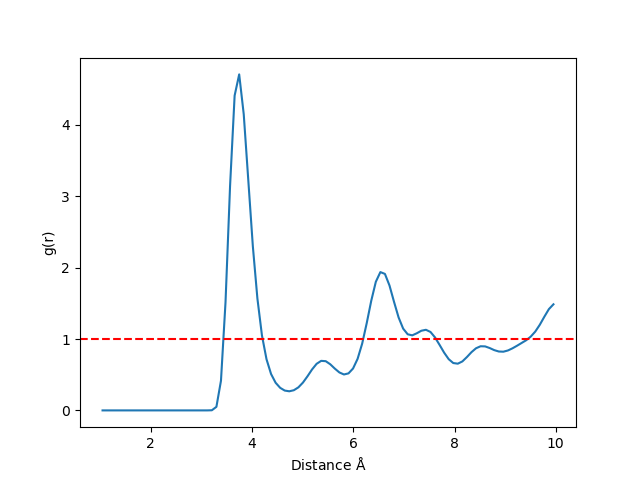

In [11]:
fig = plt.figure()
ax = fig.gca()
ax.plot(rdf.results.bins, rdf.results.rdf)
ax.axhline(1,color='red',linestyle='dashed')
ax.set(ylabel="g(r)")
ax.set(xlabel="Distance $\mathrm{\AA}$")
plt.show()

Another often useful structural information to have is the coordination number, _i.e._ the number of nearest neighbours that one species has within a certain distance $r$. This can be readily calculated from the $g(r)$ as

\begin{equation}
n(r) \int_0^r 4\pi r^2 \rho g(R)\ \mathrm{d}R
\end{equation}

Due to the way the calculation of the $g(r)$ is implemented the **not-normalised** integrand of the equation above is the quantity that is actually computed first. This is readily available as a result of the RDF calculation as _result.count_, the only thing we need to do is to normalise it.
The integral can then be replaced with a _cumulative sum_, which we get from numpy.

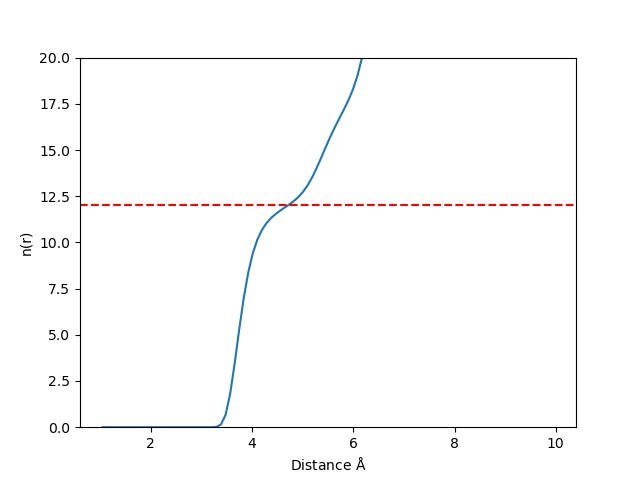

In [10]:
integrand = rdf.results.count / numberOfAtoms / nFrames
csum = np.cumsum(integrand)

fig = plt.figure()
ax = fig.gca()
ax.plot(rdf.results.bins, csum)
ax.axhline(12,color='red',linestyle='dashed')

ax.set(ylabel="n(r)")
ax.set(xlabel="Distance $\mathrm{\AA}$")

plt.ylim([0,20])
plt.show()